In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys 
sys.path.insert(0, './MotorNet/')
import motornet as mn
import tensorflow as tf
from utils import Kernel_Gaussian, state_dict_pack, state_dict_unpack, GA
import torch
from Enviroments import SeqEnv
from Tasks import SingleReach
from time import time
from tqdm import tqdm

In [3]:
plant = mn.plants.ReluPointMass24()
print("Muscle Configuration:")
print(plant.get_muscle_cfg())

Muscle Configuration:
{'UpperRight': {'n_fixation_points': 2, 'fixation body': [0, 1], 'coordinates': [[2.0, 2.0], [0.0, 0.0]], 'max_isometric_force': 500}, 'UpperLeft': {'n_fixation_points': 2, 'fixation body': [0, 1], 'coordinates': [[-2.0, 2.0], [0.0, 0.0]], 'max_isometric_force': 500}, 'LowerRight': {'n_fixation_points': 2, 'fixation body': [0, 1], 'coordinates': [[2.0, -2.0], [0.0, 0.0]], 'max_isometric_force': 500}, 'LowerLeft': {'n_fixation_points': 2, 'fixation body': [0, 1], 'coordinates': [[-2.0, -2.0], [0.0, 0.0]], 'max_isometric_force': 500}}


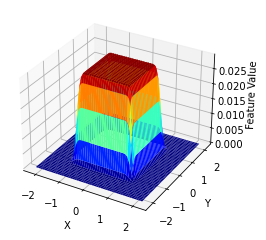

In [4]:
%matplotlib inline
x_range = np.array([-1.2,1.2])
y_range = np.array([-1.2,1.2])
n_kernel = 25
S = 0.01*np.eye(2)  
do_plot = 1
Kernel = Kernel_Gaussian(x_range, y_range, n_kernel, S, do_plot=1)

In [6]:
class GRU_model(torch.nn.Module):

    def __init__(self, **kwargs):
        super(GRU_model, self).__init__()
        
        self.conv = torch.nn.Conv3d(in_channels=2, out_channels=1, kernel_size=(1,3,3))
        self.max_pool = torch.nn.MaxPool3d(kernel_size=(1,3,3))
        self.flatten = torch.nn.Flatten(start_dim=-2, end_dim=-1)
        self.recurrent_layer = torch.nn.RNN(input_size=49, hidden_size=30, num_layers=1, bias=False, bidirectional=False, batch_first=True)
        self.linear1 = torch.nn.Linear(30, 4)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.max_pool(x)
        x = self.flatten(x)
        x = torch.squeeze(x, dim = 1)
        x, h = self.recurrent_layer(x, torch.randn(1,1,30))
        x = self.linear1(x)
        x = self.activation(x)
        return x

with torch.no_grad():
    model = GRU_model()

print('The model:')
print(model)

The model:
GRU_model(
  (conv): Conv3d(2, 1, kernel_size=(1, 3, 3), stride=(1, 1, 1))
  (max_pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 3, 3), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=-2, end_dim=-1)
  (recurrent_layer): RNN(49, 30, bias=False, batch_first=True)
  (linear1): Linear(in_features=30, out_features=4, bias=True)
  (activation): ReLU()
)


In [9]:
# Test a model
def test_model(agent):
    t1 = time()
    done = False
    max_duration = 10
    task = SingleReach(type='fix')
    env = SeqEnv(plant, Kernel, task, motor_noise_sd = 0)
    vis = env.get_init_state()
    Reward = [] # list of state, action, reward
    duration = 0

    param = state_dict_pack(model.state_dict())
    new_state_dict = state_dict_unpack(model.state_dict(), param, agent['params'])
    model.load_state_dict(new_state_dict)
    t2 = time()
    print(t2-t1)
    with torch.no_grad():
        while True:
            vis_feedback = np.expand_dims(vis.transpose(2,0,1), axis=(0,2))
            action = model(torch.from_numpy(vis_feedback).float())
            action = np.squeeze(action.numpy())
            reward, new_vis, done = env.step(action)
            vis = new_vis.copy()
            Reward.append(reward)
            duration += 1
            if (done != 0) or duration > max_duration:
                break
    return np.sum(Reward)



  0%|          | 0/2 [00:00<?, ?it/s]

0.14947080612182617
0.11782670021057129    0.09235644340515137    0.025470256805419922
0.11384081840515137    0.09178900718688965    0.02205181121826172
0.1141350269317627    0.09143400192260742    0.022701025009155273
0.10895800590515137    0.0867924690246582    0.022165536880493164
0.12247753143310547    0.09894180297851562    0.023535728454589844
0.10408639907836914    0.08129143714904785    0.02279496192932129
0.09554314613342285    0.07624363899230957    0.01929950714111328
0.11082887649536133    0.09123015403747559    0.019598722457885742
0.11202454566955566    0.09035158157348633    0.021672964096069336
0.11542558670043945    0.09366989135742188    0.021755695343017578
0.11140966415405273    0.08983111381530762    0.021578550338745117
0.12230801582336426
0.1121063232421875    0.08995175361633301    0.022154569625854492
0.11465716361999512    0.0935511589050293    0.02110600471496582
0.11175060272216797    0.0903632640838623    0.021387338638305664
0.10188651084899902    0.080822

 50%|█████     | 1/2 [00:24<00:24, 24.05s/it]

0.09369969367980957    0.07514262199401855    0.018557071685791016
0.09293127059936523    0.07471776008605957    0.018213510513305664
0.09304332733154297    0.07531499862670898    0.017728328704833984
0.10699820518493652
0.09344601631164551    0.07511043548583984    0.018335580825805664
0.09309649467468262    0.07490348815917969    0.01819300651550293
0.09447455406188965    0.07601284980773926    0.01846170425415039
0.09315609931945801    0.0748600959777832    0.018296003341674805
0.09343171119689941    0.07487654685974121    0.018555164337158203
0.10755085945129395    0.08901047706604004    0.018540382385253906
0.11501479148864746    0.09453010559082031    0.02048468589782715
0.11722850799560547    0.09545493125915527    0.021773576736450195
0.10586905479431152    0.08574438095092773    0.02012467384338379
0.11678600311279297    0.09489822387695312    0.021887779235839844
0.10437583923339844    0.08322477340698242    0.021151065826416016
0.10738492012023926
0.11332201957702637    0.09

100%|██████████| 2/2 [00:48<00:00, 24.08s/it]

0.09517312049865723    0.07654547691345215    0.018627643585205078
0.11025762557983398


0.0951833724975586    0.07715487480163574    0.01802849769592285
0.0932157039642334    0.0751190185546875    0.0180966854095459
0.09315109252929688    0.07511568069458008    0.018035411834716797
0.09522128105163574    0.07623744010925293    0.018983840942382812
0.09382104873657227    0.07545757293701172    0.018363475799560547
0.09532833099365234    0.07676005363464355    0.01856827735900879
0.09882807731628418    0.07923436164855957    0.01959371566772461
0.09572958946228027    0.07638072967529297    0.019348859786987305
0.09486103057861328    0.07566952705383301    0.019191503524780273
0.09841799736022949    0.07920074462890625    0.019217252731323242
0.09557533264160156    0.07714533805847168    0.018429994583129883
0.10959172248840332
0.09839558601379395    0.07819437980651855    0.02020120620727539
0.0956721305847168    0.0762338638305664    0.01943826675415039
0.09976673126220703    0.08007478713989258    0.019691944122314453
0.09553718566894531    0.07649922370910645    0.019037

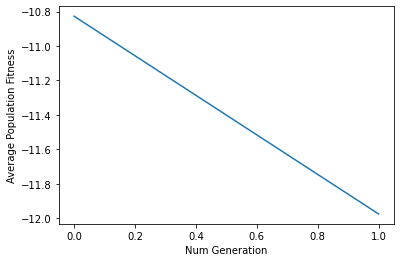

In [10]:
ga = GA(num_pop=20, cost_fun=test_model, mut_rate=0.01, tournament_size=0.2)
param = state_dict_pack(model.state_dict())
ga.run_GA(num_generations=2, num_var = len(param['val_flatten']))
ga.plot_cost()

### Random

In [ ]:
# Test a model
def test_model(agent):
    done = False
    max_duration = 100
    task = SingleReach(type='fix')
    env = SeqEnv(plant, Kernel, task, motor_noise_sd = 0)
    vis = env.get_init_state()
    Reward = [] # list of state, action, reward
    duration = 0

    param = state_dict_pack(model.state_dict())
    new_state_dict = state_dict_unpack(model.state_dict(), param, agent['params'])
    model.load_state_dict(new_state_dict)

    with torch.no_grad():
        while True:
            vis_feedback = np.expand_dims(vis.transpose(2,0,1), axis=(0,2))
            action = model(torch.from_numpy(vis_feedback).float())
            action = np.squeeze(action.numpy())
            reward, new_vis, done = env.step(action)
            vis = new_vis.copy()
            Reward.append(reward)
            duration += 1
            if (done != 0) or duration > max_duration:
                break
    return np.sum(Reward)
plt.imshow(env.get_init_state()[:,:,0])

In [ ]:
num_step = 100
vel = np.zeros((num_step, 2))
pos = np.zeros((num_step, 2))
rew = np.zeros((num_step, 1))
for st in range(num_step):
    reward, visual_feedback, trial_state = env.step([0.01,0,0.01,0])
    pos[st] =  env.cart_state.numpy()[0,0:2] 
    vel[st] = env.cart_state.numpy()[0,2:] 
    rew[st] = reward

plt.subplot(1,3,1)
plt.plot(pos[:,0], pos[:,1])
plt.scatter(pos[-1,0], pos[-1,1])
plt.subplot(1,3,2)
plt.plot((vel[:,0]**2 + vel[:,1]**2))
plt.subplot(1,3,3)
plt.plot(rew)

In [ ]:
m = 10  # Point mass

z0 = np.array([[0,0,0,0]]).T
z = np.copy(z0)

dt = 0.01
Kv = 0.1

A = np.array([[0, 0, 1, 0],
             [0, 0, 0, 1],
             [0, 0, -Kv, 0],
             [0, 0, 0, -Kv]])
B = np.array([[0, 0, 0, 0], 
             [0, 0, 0, 0],
             [-1, 1, -1, 1],
             [1, 1, -1, -1]]) * (np.sqrt(2)/2)

num_step = 1000
Z = np.zeros((num_step, 4))
for n in range(num_step):
    u = np.array([[0.2,0,0,1]]).T
    z = z + (A@z + B@u) * dt
    Z[n]= z.reshape(-1)

plt.subplot(1,2,1)
plt.plot(Z[:, 0],Z[:, 1])
plt.subplot(1,2,2)
plt.plot((Z[:, 2]**2+Z[:, 3]**2))
plt.show()